# Contrastive Autoencoder for Hand Gesture Prediction

This notebook implements an autoencoder with contrastive loss to learn a latent representation that maximizes inter-class separation for online hand gesture prediction.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import time
from sklearn.manifold import TSNE

In [11]:
# Feature Extractor (same as original)
class HandFeatureExtractor:
    """
    Extract normalized, motion-invariant features from hand tracking data.
    """
    def __init__(self):
        self.prev_frame = None
        
    def extract(self, left_hand, right_hand):
        """
        Returns feature vector for one frame
        """
        features = []
        
        # 1. Normalized positions (relative to wrist, scaled by hand size)
        left_normalized = self.normalize_hand(left_hand)
        right_normalized = self.normalize_hand(right_hand)
        features.extend([left_normalized, right_normalized])
        
        # 2. Velocities (frame-to-frame differences)
        if self.prev_frame is not None:
            left_velocity = left_hand - self.prev_frame['left']
            right_velocity = right_hand - self.prev_frame['right']
            features.extend([left_velocity, right_velocity])
        else:
            features.extend([np.zeros_like(left_hand), np.zeros_like(right_hand)])
        
        # 3. Inter-hand features
        hand_distance = np.linalg.norm(
            self.get_palm_center(left_hand) - self.get_palm_center(right_hand)
        )
        hand_relative_pos = self.get_palm_center(right_hand) - self.get_palm_center(left_hand)
        features.extend([np.array([hand_distance]), hand_relative_pos])
        
        # 4. Hand orientation/rotation features
        left_orientation = self.compute_hand_orientation(left_hand)
        right_orientation = self.compute_hand_orientation(right_hand)
        features.extend([left_orientation, right_orientation])
        
        # Update history
        self.prev_frame = {'left': left_hand.copy(), 'right': right_hand.copy()}
        
        # Flatten to 1D vector
        return np.concatenate([f.flatten() for f in features])
    
    def normalize_hand(self, landmarks):
        """
        Normalize to wrist position and scale
        """
        wrist = landmarks[0]  # Wrist is first landmark
        palm = landmarks[1]   # Palm is second landmark
        
        # Translation invariance - center at wrist
        centered = landmarks - wrist
        
        # Scale invariance - normalize by wrist-to-palm distance
        hand_scale = np.linalg.norm(palm - wrist) + 1e-6
        normalized = centered / hand_scale
        
        return normalized
    
    def get_palm_center(self, landmarks):
        """Calculate center of palm"""
        return landmarks[1]
    
    def compute_hand_orientation(self, landmarks):
        """
        Compute hand orientation using palm normal vector
        """
        wrist = landmarks[0]
        palm = landmarks[1]
        index_base = landmarks[6]  # IndexMetacarpal
        
        # Normal vector to palm plane
        v1 = palm - wrist
        v2 = index_base - wrist
        normal = np.cross(v1, v2)
        normal = normal / (np.linalg.norm(normal) + 1e-6)
        
        return normal
    
    def reset(self):
        """Reset the feature extractor state"""
        self.prev_frame = None

def parse_hand_landmarks(df):
    """
    Parse hand landmark data from DataFrame
    """
    landmark_names = [
        'Wrist', 'Palm', 'ThumbMetacarpal', 'ThumbProximal', 'ThumbDistal', 'ThumbTip',
        'IndexMetacarpal', 'IndexProximal', 'IndexIntermediate', 'IndexDistal', 'IndexTip',
        'MiddleMetacarpal', 'MiddleProximal', 'MiddleIntermediate', 'MiddleDistal', 'MiddleTip',
        'RingMetacarpal', 'RingProximal', 'RingIntermediate', 'RingDistal', 'RingTip',
        'LittleMetacarpal', 'LittleProximal', 'LittleIntermediate', 'LittleDistal', 'LittleTip'
    ]
    
    num_frames = len(df)
    landmarks = np.zeros((num_frames, 26, 3))
    
    for i, name in enumerate(landmark_names):
        landmarks[:, i, 0] = df[f'{name}_x'].values
        landmarks[:, i, 1] = df[f'{name}_y'].values
        landmarks[:, i, 2] = df[f'{name}_z'].values
    
    return landmarks

def load_data_windows(root_dir, window_size=10, stride=1):
    """
    Load data and create sliding windows
    """
    pattern = re.compile(r".*_hand_joints_.*.csv$")
    
    windows = []
    labels = []
    label_to_int = {}
    gesture_counter = 0
    
    print("Loading data and creating windows...")
    
    gesture_classes = [d for d in os.listdir(root_dir) if not d.startswith('.') and os.path.isdir(os.path.join(root_dir, d))]
    
    for gesture in sorted(gesture_classes):
        if gesture not in label_to_int:
            label_to_int[gesture] = gesture_counter
            gesture_counter += 1
            
        gesture_dir = os.path.join(root_dir, gesture)
        recordings = sorted([r for r in os.listdir(gesture_dir) if not r.startswith('.') and os.path.isdir(os.path.join(gesture_dir, r))])
        
        for rec in recordings:
            rec_dir = os.path.join(gesture_dir, rec)
            files = sorted([f for f in os.listdir(rec_dir) if pattern.search(f)])
            
            if len(files) < 2: continue
            
            left_file = [f for f in files if 'left' in f.lower()]
            right_file = [f for f in files if 'right' in f.lower()]
            
            if not left_file or not right_file: continue
            
            # Load and parse
            try:
                left_df = pd.read_csv(os.path.join(rec_dir, left_file[0]))
                right_df = pd.read_csv(os.path.join(rec_dir, right_file[0]))
                
                left_landmarks = parse_hand_landmarks(left_df)
                right_landmarks = parse_hand_landmarks(right_df)
                
                min_frames = min(len(left_landmarks), len(right_landmarks))
                
                # Extract features
                extractor = HandFeatureExtractor()
                features = []
                for t in range(min_frames):
                    feat = extractor.extract(left_landmarks[t], right_landmarks[t])
                    features.append(feat)
                
                features = np.array(features)
                
                # Create windows
                if len(features) >= window_size:
                    for i in range(0, len(features) - window_size + 1, stride):
                        window = features[i:i+window_size]
                        windows.append(window)
                        labels.append(label_to_int[gesture])
                        
            except Exception as e:
                print(f"Error processing {rec_dir}: {e}")
                continue
                
    return np.array(windows), np.array(labels), label_to_int

In [12]:
# Load data
WINDOW_SIZE = 10
X_windows, y_windows, label_map = load_data_windows('./data/new_data', window_size=WINDOW_SIZE)

print(f"Loaded {len(X_windows)} windows")
print(f"Window shape: {X_windows.shape}")
print(f"Classes: {label_map}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Loading data and creating windows...
Loaded 821 windows
Window shape: (821, 10, 322)
Classes: {'clap': 0, 'double': 1, 'front_five': 2, 'left_five': 3, 'right_five': 4}


In [13]:
# Contrastive Autoencoder Model

class TemporalEncoder(nn.Module):
    """Encode temporal sequences into latent representation"""
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        # x: (batch, window_size, features)
        out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        h_last = out[:, -1, :]
        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        return mu, logvar

class TemporalDecoder(nn.Module):
    """Decode latent representation back to temporal sequence"""
    def __init__(self, latent_dim, hidden_dim, output_dim, window_size):
        super().__init__()
        self.window_size = window_size
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        # z: (batch, latent_dim)
        h = self.fc(z)
        # Repeat for window_size timesteps
        h = h.unsqueeze(1).repeat(1, self.window_size, 1)
        out, _ = self.lstm(h)
        out = self.fc_out(out)
        return out

class ContrastiveAutoencoder(nn.Module):
    """Autoencoder with contrastive loss for gesture recognition"""
    def __init__(self, input_dim, hidden_dim, latent_dim, window_size, num_classes):
        super().__init__()
        self.encoder = TemporalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = TemporalDecoder(latent_dim, hidden_dim, input_dim, window_size)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        logits = self.classifier(z)
        return x_recon, z, mu, logvar, logits

class SupConLoss(nn.Module):
    """Supervised Contrastive Loss"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        """
        Args:
            features: (batch_size, latent_dim) - normalized latent features
            labels: (batch_size,) - class labels
        """
        device = features.device
        batch_size = features.shape[0]
        
        # Normalize features
        features = F.normalize(features, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature
        
        # Create mask for positive pairs (same class)
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Mask out self-similarity
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # Compute log probabilities
        exp_logits = torch.exp(similarity_matrix) * logits_mask
        log_prob = similarity_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        
        # Compute mean of log-likelihood over positive pairs
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-6)
        
        # Loss is negative log-likelihood
        loss = -mean_log_prob_pos.mean()
        
        return loss

In [14]:
def train_contrastive_ae(model, train_loader, test_loader, num_epochs=50, lr=0.001, 
                         alpha=1.0, beta=0.5, gamma=0.01):
    """
    Train contrastive autoencoder
    
    Loss = alpha * reconstruction_loss + beta * contrastive_loss + gamma * KL_loss + classification_loss
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss functions
    recon_criterion = nn.MSELoss()
    contrastive_criterion = SupConLoss(temperature=0.07)
    class_criterion = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    history = {
        'train_loss': [],
        'recon_loss': [],
        'contrastive_loss': [],
        'kl_loss': [],
        'class_loss': [],
        'test_accuracy': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        recon_loss_sum = 0.0
        contrastive_loss_sum = 0.0
        kl_loss_sum = 0.0
        class_loss_sum = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, z, mu, logvar, logits = model(inputs)
            
            # Reconstruction loss
            recon_loss = recon_criterion(x_recon, inputs)
            
            # Contrastive loss
            contrastive_loss = contrastive_criterion(mu, labels)
            
            # KL divergence loss (regularization)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / inputs.size(0)
            
            # Classification loss
            class_loss = class_criterion(logits, labels)
            
            # Combined loss
            loss = alpha * recon_loss + beta * contrastive_loss + gamma * kl_loss + class_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            recon_loss_sum += recon_loss.item()
            contrastive_loss_sum += contrastive_loss.item()
            kl_loss_sum += kl_loss.item()
            class_loss_sum += class_loss.item()
        
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        history['recon_loss'].append(recon_loss_sum / len(train_loader))
        history['contrastive_loss'].append(contrastive_loss_sum / len(train_loader))
        history['kl_loss'].append(kl_loss_sum / len(train_loader))
        history['class_loss'].append(class_loss_sum / len(train_loader))
        
        scheduler.step(avg_loss)
        
        # Evaluate
        model.eval()
        all_preds = []
        all_labels = []
        all_embeddings = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                _, z, mu, _, logits = model(inputs)
                _, preds = torch.max(logits, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_embeddings.append(mu.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        history['test_accuracy'].append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Total Loss: {avg_loss:.4f}')
            print(f'  Recon: {history["recon_loss"][-1]:.4f}, Contrastive: {history["contrastive_loss"][-1]:.4f}, '
                  f'KL: {history["kl_loss"][-1]:.4f}, Class: {history["class_loss"][-1]:.4f}')
            print(f'  Test Accuracy: {accuracy:.4f}')
    
    end_time = time.time()
    print(f"\nTraining time: {end_time - start_time:.2f}s")
    
    return history, all_labels, all_preds, np.concatenate(all_embeddings)

In [15]:
# Initialize model
input_dim = X_train.shape[2]
output_dim = len(label_map)
hidden_dim = 128
latent_dim = 64

model = ContrastiveAutoencoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    window_size=WINDOW_SIZE,
    num_classes=output_dim
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Input dim: {input_dim}, Latent dim: {latent_dim}, Classes: {output_dim}")

# Train model
history, test_labels, test_preds, test_embeddings = train_contrastive_ae(
    model, train_loader, test_loader, 
    num_epochs=50, lr=0.001,
    alpha=1.0,   # reconstruction weight
    beta=0.5,    # contrastive weight
    gamma=0.01   # KL weight
)

Model parameters: 703047
Input dim: 322, Latent dim: 64, Classes: 5
Epoch [5/50]
  Total Loss: 2.3056
  Recon: 0.0046, Contrastive: 2.0448, KL: 5.9063, Class: 1.2195
  Test Accuracy: 0.7455
Epoch [10/50]
  Total Loss: 1.1761
  Recon: 0.0023, Contrastive: 1.8559, KL: 15.2507, Class: 0.0933
  Test Accuracy: 0.9576
Epoch [15/50]
  Total Loss: 1.0670
  Recon: 0.0020, Contrastive: 1.8063, KL: 10.9907, Class: 0.0519
  Test Accuracy: 0.9273
Epoch [20/50]
  Total Loss: 1.0259
  Recon: 0.0017, Contrastive: 1.7771, KL: 10.1908, Class: 0.0337
  Test Accuracy: 0.9939
Epoch [25/50]
  Total Loss: 1.0169
  Recon: 0.0016, Contrastive: 1.7843, KL: 9.2294, Class: 0.0309
  Test Accuracy: 0.9576
Epoch [30/50]
  Total Loss: 0.9843
  Recon: 0.0015, Contrastive: 1.7416, KL: 8.7019, Class: 0.0249
  Test Accuracy: 1.0000
Epoch [35/50]
  Total Loss: 0.9771
  Recon: 0.0016, Contrastive: 1.7582, KL: 7.9877, Class: 0.0166
  Test Accuracy: 0.9879
Epoch [40/50]
  Total Loss: 0.9938
  Recon: 0.0015, Contrastive: 1.77

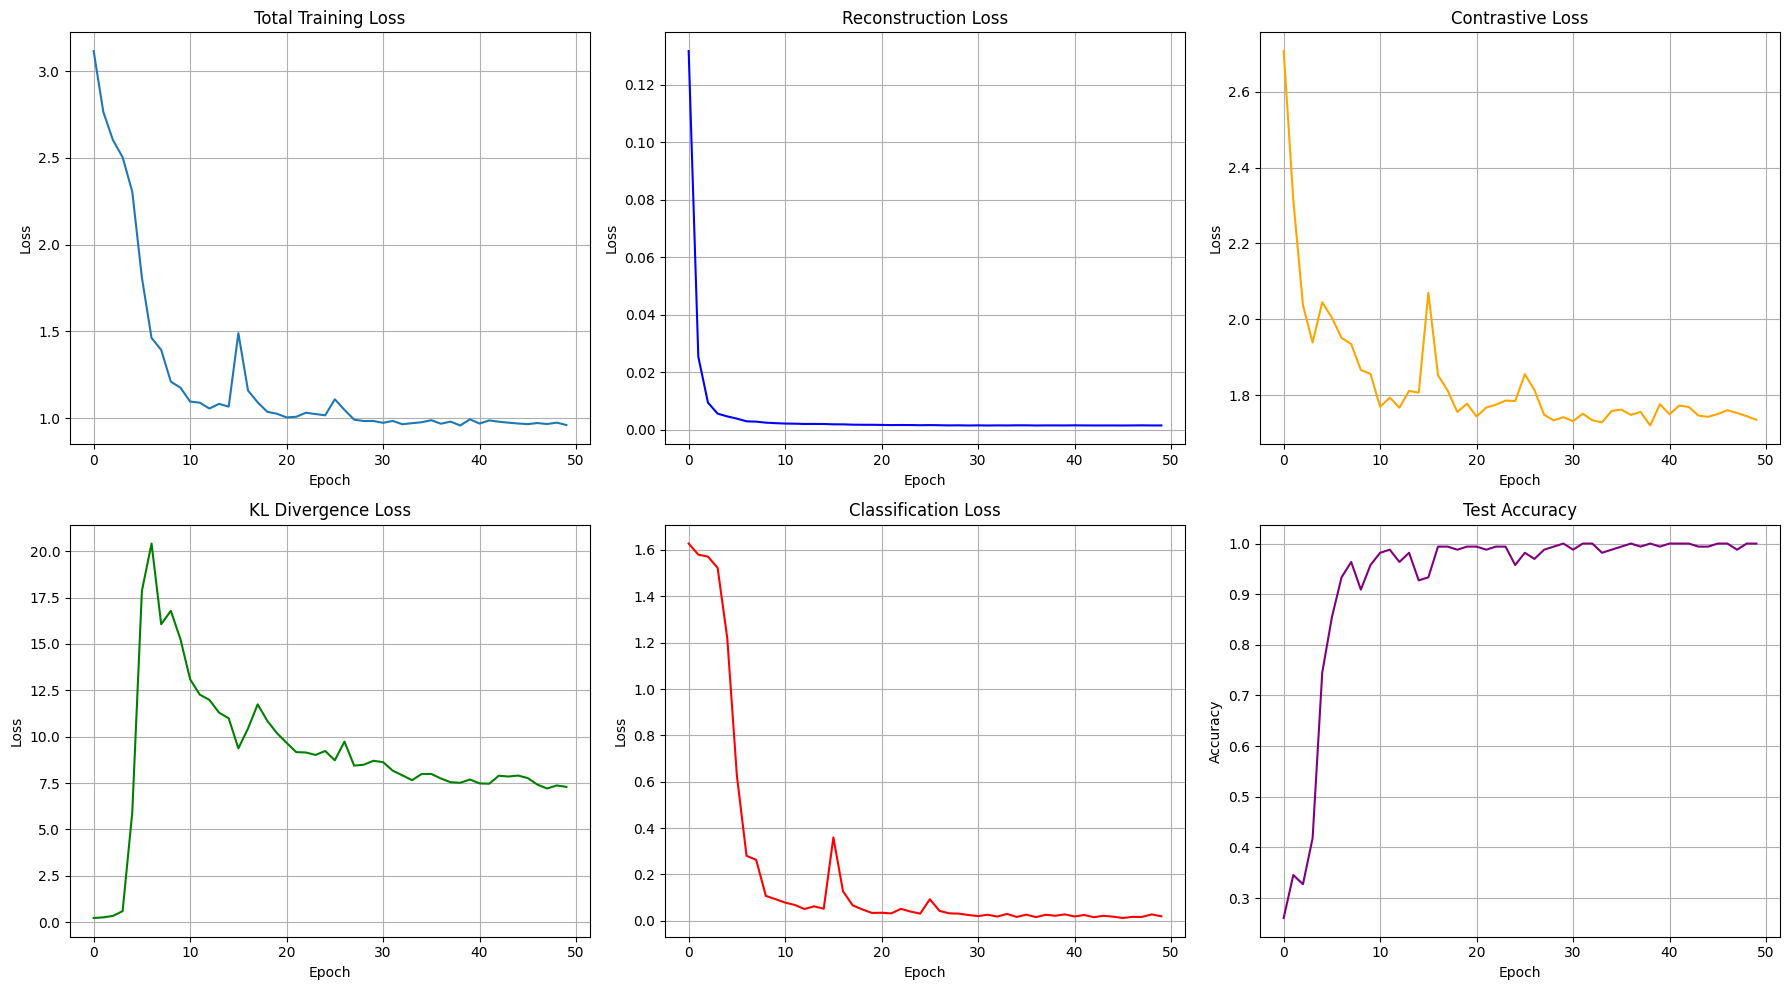


Final Test Accuracy: 1.0000
Best Test Accuracy: 1.0000


In [16]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
axes[0, 0].plot(history['train_loss'])
axes[0, 0].set_title('Total Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# Reconstruction loss
axes[0, 1].plot(history['recon_loss'], label='Reconstruction', color='blue')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

# Contrastive loss
axes[0, 2].plot(history['contrastive_loss'], label='Contrastive', color='orange')
axes[0, 2].set_title('Contrastive Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True)

# KL loss
axes[1, 0].plot(history['kl_loss'], label='KL Divergence', color='green')
axes[1, 0].set_title('KL Divergence Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Classification loss
axes[1, 1].plot(history['class_loss'], label='Classification', color='red')
axes[1, 1].set_title('Classification Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True)

# Test accuracy
axes[1, 2].plot(history['test_accuracy'], label='Test Accuracy', color='purple')
axes[1, 2].set_title('Test Accuracy')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {history['test_accuracy'][-1]:.4f}")
print(f"Best Test Accuracy: {max(history['test_accuracy']):.4f}")

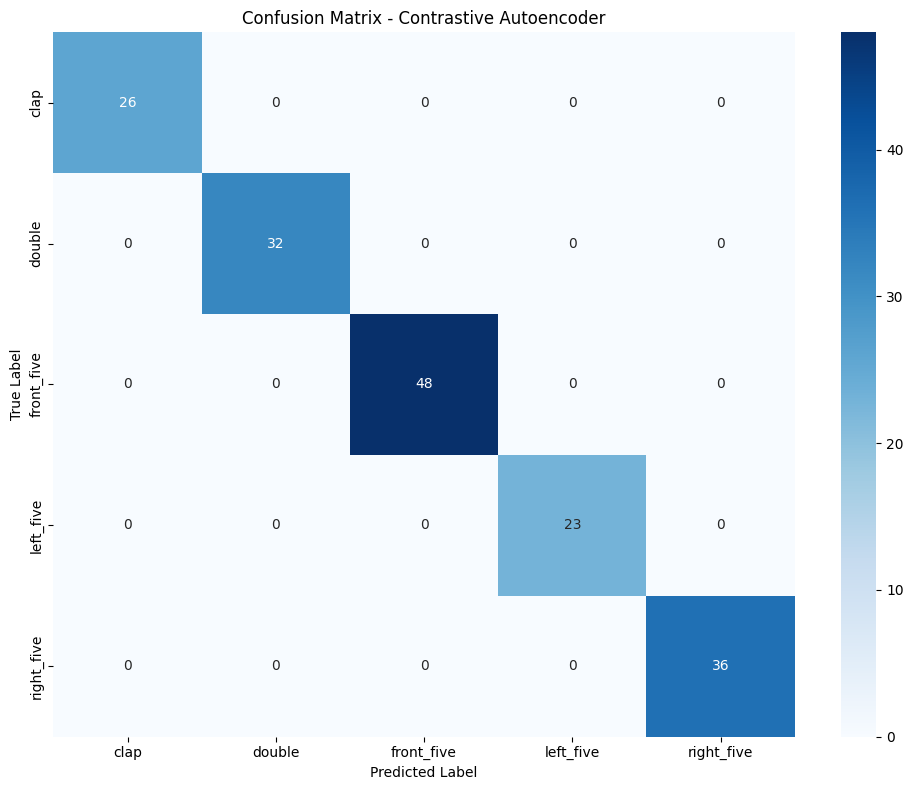

In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.title('Confusion Matrix - Contrastive Autoencoder')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Computing t-SNE embedding...


/Users/ingui/Documents/Projects/ece_project/Hand-Clap-Robot/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ingui/Documents/Projects/ece_project/Hand-Clap-Robot/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ingui/Documents/Projects/ece_project/Hand-Clap-Robot/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ingui/Documents/Projects/ece_project/Hand-Clap-Robot/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ingui/Documents/Projects/ece_project/Hand-Clap-Robot/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = norm

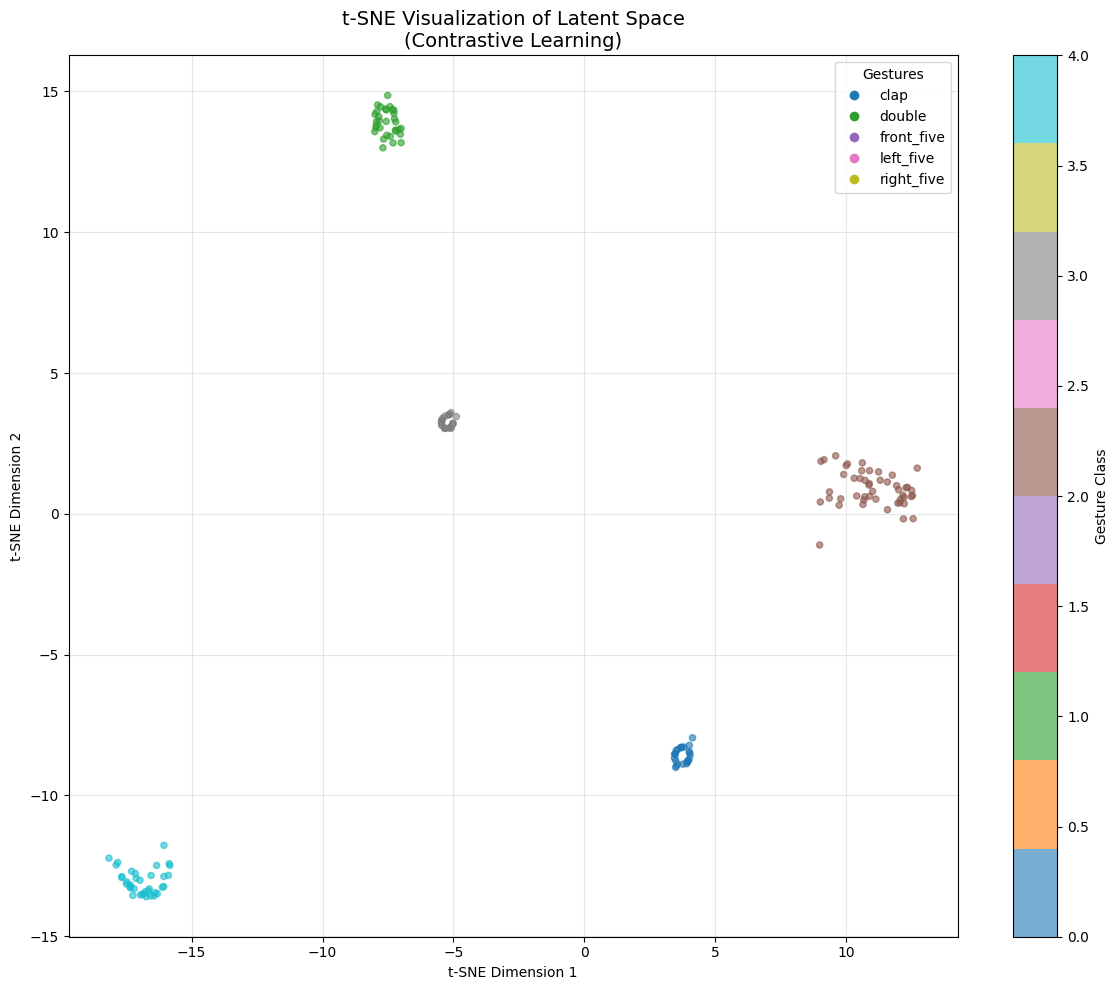


Note: Clusters should be well-separated due to contrastive learning.


In [ ]:
# Visualize latent space with t-SNE
print("Computing t-SNE embedding...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=test_labels, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Gesture Class')
plt.title('t-SNE Visualization of Latent Space\n(Contrastive Learning)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add legend with gesture names
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=plt.cm.tab10(i/len(label_map)), 
                     markersize=8, label=gesture) 
          for gesture, i in sorted(label_map.items(), key=lambda x: x[1])]
plt.legend(handles=handles, loc='best', title='Gestures')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/6m/mrzmm89n3x3dlb7n0lc_bqwh0000gn/T/ipykernel_94958/2999725056.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Intra-class', 'Inter-class'])


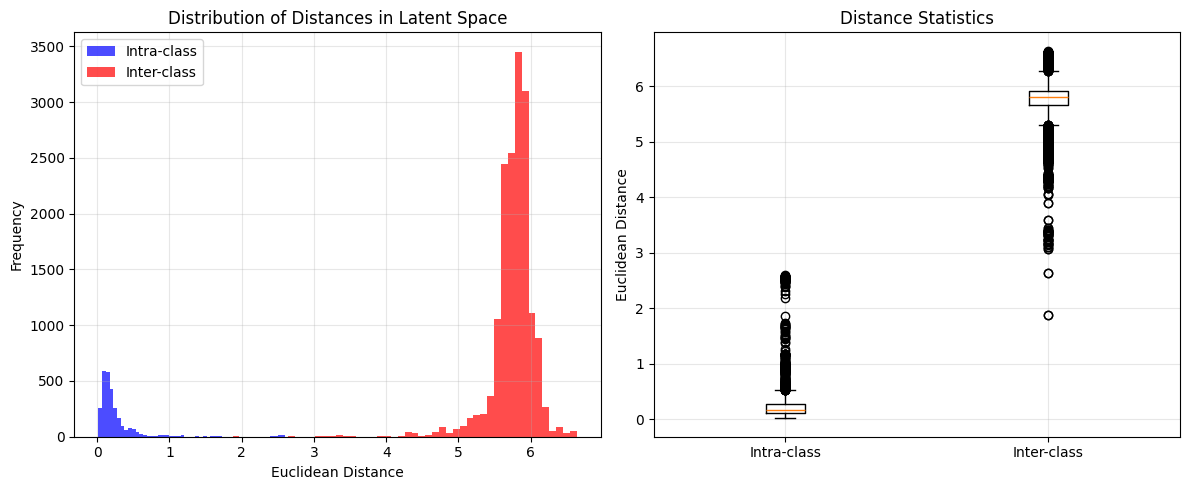

Mean intra-class distance: 0.2748 ± 0.3724
Mean inter-class distance: 5.7618 ± 0.2987
Separation ratio (inter/intra): 20.9648

A higher separation ratio indicates better class separation in latent space.


In [ ]:
# Compute inter-class and intra-class distances in latent space
def compute_class_distances(embeddings, labels):
    unique_labels = np.unique(labels)
    intra_class_dists = []
    inter_class_dists = []
    
    for label in unique_labels:
        class_embeddings = embeddings[labels == label]
        
        # Intra-class distances (within same class)
        if len(class_embeddings) > 1:
            for i in range(len(class_embeddings)):
                for j in range(i+1, len(class_embeddings)):
                    dist = np.linalg.norm(class_embeddings[i] - class_embeddings[j])
                    intra_class_dists.append(dist)
        
        # Inter-class distances (between different classes)
        other_embeddings = embeddings[labels != label]
        for i in range(len(class_embeddings)):
            for j in range(min(len(other_embeddings), 100)):  # Sample for efficiency
                dist = np.linalg.norm(class_embeddings[i] - other_embeddings[j])
                inter_class_dists.append(dist)
    
    return np.array(intra_class_dists), np.array(inter_class_dists)

intra_dists, inter_dists = compute_class_distances(test_embeddings, np.array(test_labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(intra_dists, bins=50, alpha=0.7, label='Intra-class', color='blue')
plt.hist(inter_dists, bins=50, alpha=0.7, label='Inter-class', color='red')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances in Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
data = [intra_dists, inter_dists]
plt.boxplot(data, labels=['Intra-class', 'Inter-class'])
plt.ylabel('Euclidean Distance')
plt.title('Distance Statistics')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean intra-class distance: {intra_dists.mean():.4f} ± {intra_dists.std():.4f}")
print(f"Mean inter-class distance: {inter_dists.mean():.4f} ± {inter_dists.std():.4f}")
print(f"Separation ratio (inter/intra): {inter_dists.mean() / intra_dists.mean():.4f}")

In [20]:
# Save model
model_save_path = './models/contrastive_autoencoder.pt'
os.makedirs('./models', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'label_map': label_map,
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'window_size': WINDOW_SIZE,
    'test_accuracy': history['test_accuracy'][-1]
}, model_save_path)

print(f"Model saved to {model_save_path}")
print(f"Final test accuracy: {history['test_accuracy'][-1]:.4f}")

Model saved to ./models/contrastive_autoencoder.pt
Final test accuracy: 1.0000
